In [1]:
from SVDModel import SVDModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import pickle
import os.path
from pathlib import Path

np.random.seed(3362)

In [2]:
# Parameters
PARAM = dict()
PARAM['path'] = {
  'ml':'./data/MovieLens25M/',
  'netflix':'./data/NetflixPrize/'
}

PARAM

{'path': {'ml': './data/MovieLens25M/', 'netflix': './data/NetflixPrize/'}}

In [3]:
# ML_25M = {
#   'ratings': pd.read_csv(PARAM['path']['ml']+'ratings.csv', dtype={
#     'userId': np.int32,
#     'movieId': np.int32,
# #     'rating': np.float64,
#     'timestamp':np.float64}).sample(2**16),
#   'movies': pd.read_csv(PARAM['path']['ml']+'movies.csv', dtype= {
#     'movieId':np.int32,
#     'title': str,
#     'genres': str
#   })
# }
# ML_25M['m_movies'] = ML_25M['movies']['movieId'].nunique()
# ML_25M['n_users'] = ML_25M['ratings']['userId'].nunique()
# ML_25M['n_ratings'] = len(ML_25M['ratings'])


# ML_25M['movies'].insert(1, 'newMovieId', value=range(1,len(ML_25M['movies'])+1))
# newMovieIdDict = {}
# for index, movie in ML_25M['movies'].iterrows():
#     newMovieIdDict[movie['movieId']] = movie['newMovieId']
# ML_25M['ratings'].replace({"movieId": newMovieIdDict}, inplace=True)
# ML_25M['ratings']['rating'] = ML_25M['ratings']['rating'].astype(np.float16)

# ML_25M

In [4]:
# print(ML_25M['ratings'].size)
# print(ML_25M['movies'].size)

In [3]:
names = ['userId','rating','timestamp','movieId']
df_netflix = pd.read_csv(PARAM['path']['netflix']+'data_1.txt', names=names, low_memory=False)
df_netflix_2 = pd.read_csv(PARAM['path']['netflix']+'data_2.txt', names=names, low_memory=False)
df_netflix_3 = pd.read_csv(PARAM['path']['netflix']+'data_3.txt', names=names, low_memory=False)
df_netflix_4 = pd.read_csv(PARAM['path']['netflix']+'data_4.txt', names=names, low_memory=False)
df_netflix = pd.concat([df_netflix,df_netflix_2,df_netflix_3,df_netflix_4], names=names)
df_netflix['movieId'] = df_netflix['movieId'].fillna(method='ffill')
df_netflix.dropna(inplace=True)
df_netflix['rating'] = df_netflix['rating'].astype(np.int8)
df_netflix['movieId'] = df_netflix['movieId'].astype(np.int16)
df_netflix['userId'] = df_netflix['userId'].astype(np.int32)
df_netflix['timestamp'] = pd.to_datetime(df_netflix['timestamp']).view(dtype=np.int64) // 10 ** 9
df_movies = pd.read_csv(PARAM['path']['netflix']+'movie_titles.csv',
                        encoding='latin-1',
                        names=['movieId','release_year','title'],
                        usecols=range(3))
NETFLIX = {
  'ratings': df_netflix[['userId','movieId','rating','timestamp']].sample(2**12),
  'movies': df_movies,
  'm_movies': df_netflix['movieId'].nunique(),
  'n_users': df_netflix['userId'].nunique(),
  'n_ratings': len(df_netflix)
}


In [4]:
print(NETFLIX['ratings'].shape)
print(NETFLIX['movies'].shape)

(4096, 4)
(17770, 3)


In [5]:
PARAM['features'] = [3,5,10,100,200,300]
PARAM['lr'] = [1e-2,1e-3,1e-4,1e-5]
PARAM['epochs'] = [11,101,201,301,501,1001]
PARAM['weight_decay'] = [0.02,0.2,2]
PARAM['stopping'] = 0.001

def train_model(features, lr, epochs, data, weight_decay):
    print(f"==============================")
    print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n')
    if os.path.isfile(f'./model_netflix/funk/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
        return
    print('Creating SVD Model')
    svd = SVDModel(
        features=features, 
        lr=lr, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        stopping=PARAM['stopping']
    )
    print("Created\nLoading Data")
    if data=='ML_25M':
        svd.data_loader(data=ML_25M['ratings'], 
                        n_items = ML_25M['m_movies'], 
                        n_users= ML_25M['n_users'])
    else:
        svd.data_loader(data=NETFLIX['ratings'], 
                        n_items = NETFLIX['m_movies'], 
                        n_users= NETFLIX['n_users'])
    print("Loaded Data\nSpliting Data")
    svd.split(0.6,0.8)
    print("Splitted Data\nTraining...")
    start = time.perf_counter()
    result = svd.training()
    print('Time used =', time.perf_counter()-start)
    
    print('Saving Model')
    svd.data = []
    Path("./model_netflix").mkdir(parents=True, exist_ok=True)
    Path("./model_netflix/funk").mkdir(parents=True, exist_ok=True)
    Path("./model_netflix/funk/model").mkdir(parents=True, exist_ok=True)
    Path("./model_netflix/funk/result").mkdir(parents=True, exist_ok=True)
    
    with open(f'./model_netflix/funk/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
        pickle.dump(svd, out, pickle.HIGHEST_PROTOCOL)
        out.close()
    with open(f'./model_netflix/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
        pickle.dump(result, out, pickle.HIGHEST_PROTOCOL)
        out.close()
    print(f"==============================")
    return svd, results

In [6]:
for epochs in PARAM['epochs']:
    for features in PARAM['features']:
        for lr in PARAM['lr']:
            for weight_decay in PARAM['weight_decay']:
                for data in ['NETFLIX']:
                    train_model(features, lr, epochs, data, weight_decay)

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001

features: 3
learning rate: 1e-05
Epochs: 11
weight decay: 0.02
stopping: 0.001

features: 3
learning rate: 1e-05
Epochs: 11
weight decay: 0.2
stopping: 0.001

features: 3
learning rate: 1e-05
Epochs: 11
weight decay: 2
stopping: 0.001

features: 5
learning rate: 0.01
Epochs: 11
weight decay:

User Item Matrix Shape: (4039, 2140)
User Reference length: 4039
Item Reference length: 2140
Splitted Data
Training...
Epoch :    1  | Train : 14.319  | Valid : 14.428  | Time : 8.02507s
Epoch :   11  | Train : 14.164  | Valid : 14.402  | Time : 92.92357s
Epoch :   21  | Train : 13.601  | Valid : 14.354  | Time : 84.93464s
Epoch :   31  | Train : 12.045  | Valid : 14.268  | Time : 86.64970s
Epoch :   41  | Train : 9.619  | Valid : 14.155  | Time : 92.21276s
Epoch :   51  | Train : 7.118  | Valid : 14.045  | Time : 85.44682s
Epoch :   61  | Train : 4.940  | Valid : 13.950  | Time : 81.19141s
Epoch :   71  | Train : 3.226  | Valid : 13.874  | Time : 89.03799s
Epoch :   81  | Train : 2.035  | Valid : 13.818  | Time : 87.94788s
Epoch :   91  | Train : 1.282  | Valid : 13.781  | Time : 88.24398s
Epoch :  101  | Train : 0.823  | Valid : 13.756  | Time : 89.43212s
Training stopped:
Epoch :  101  | Train : 0.823  | Valid : 13.756
Time used = 886.0498465000001
Saving Model
features: 3
learning 

Epoch :   91  | Train : 14.068  | Valid : 14.329  | Time : 181.24648s
Epoch :  101  | Train : 14.068  | Valid : 14.329  | Time : 208.49767s
Training stopped:
Epoch :  101  | Train : 14.068  | Valid : 14.329
Time used = 2022.7686373999995
Saving Model
features: 3
learning rate: 1e-05
Epochs: 101
weight decay: 2
stopping: 0.001

Creating SVD Model
Created
Loading Data
Loaded Data
Spliting Data
User Item Matrix Shape: (4039, 2140)
User Reference length: 4039
Item Reference length: 2140
Splitted Data
Training...
Epoch :    1  | Train : 14.496  | Valid : 13.796  | Time : 15.01320s


KeyboardInterrupt: 

# Graph
$$MSE=\frac{1}{N}\sum_{i=1}^N(predict_i-actual_i)^2$$
$$RMSE=\sqrt{\frac{\sum_{i=1}^N(predict_i-actual_i)^2}{N}}$$

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.263299724277744
RMSE
3.7766783983121655


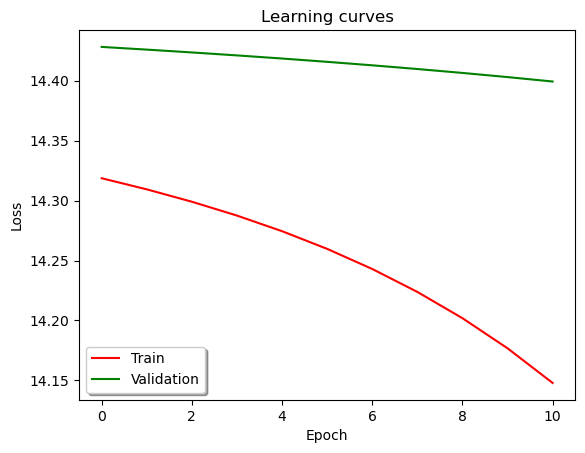

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.103863696218712
RMSE
3.7555111098515885


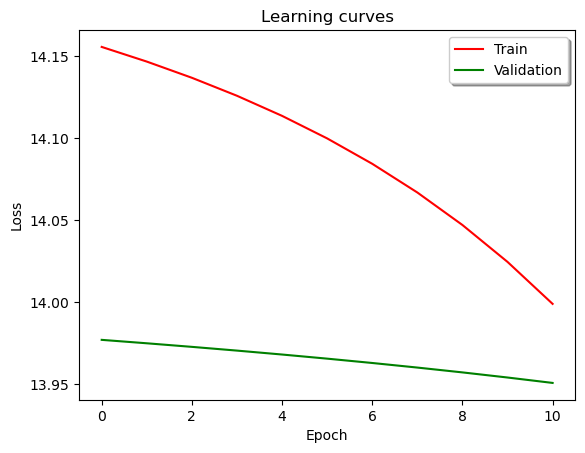

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.295242475939592
RMSE
3.7809049810778887


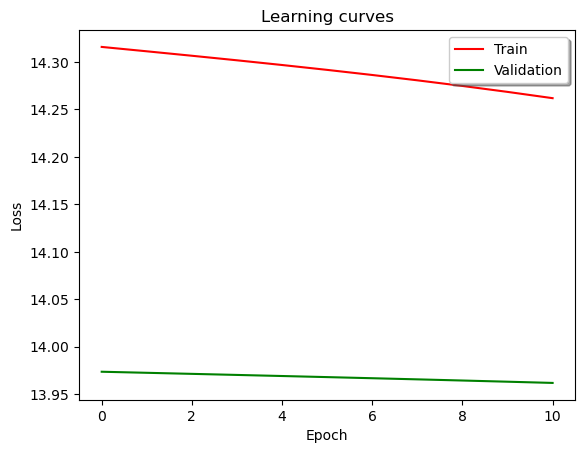

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.28611656554518
RMSE
3.779697946337138


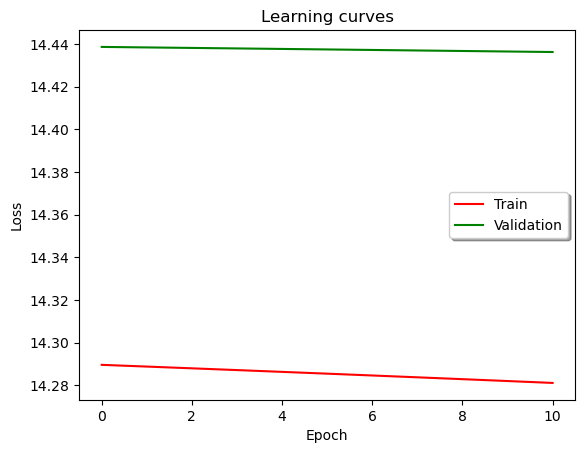

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.233636551480016
RMSE
3.7727492033635124


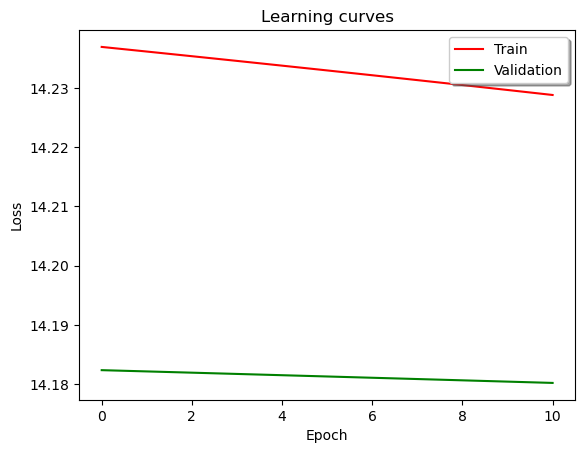

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.330464012158446
RMSE
3.7855599337691705


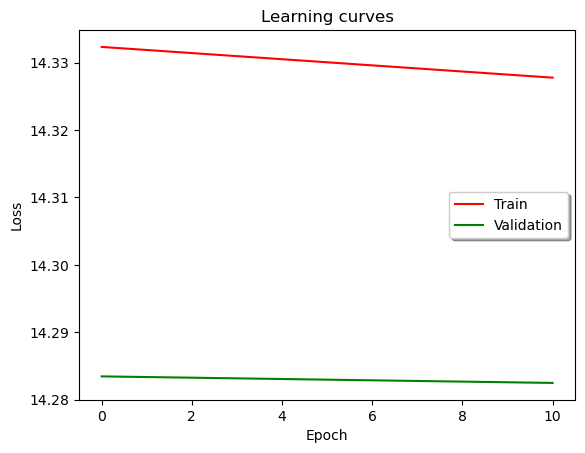

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.446945793187169
RMSE
3.800913810281308


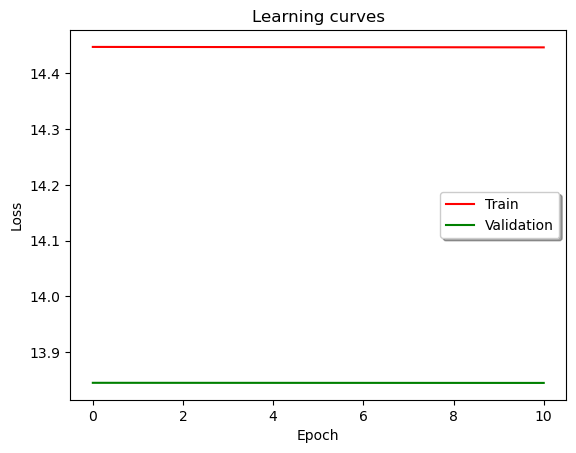

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.061887946812536
RMSE
3.7499183920203567


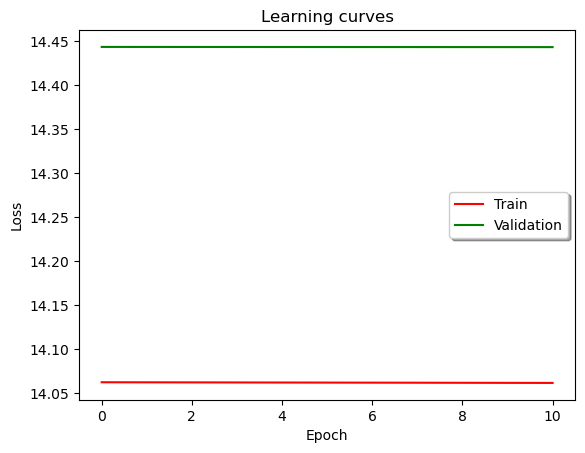

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.136634814763344
RMSE
3.7598716487086823


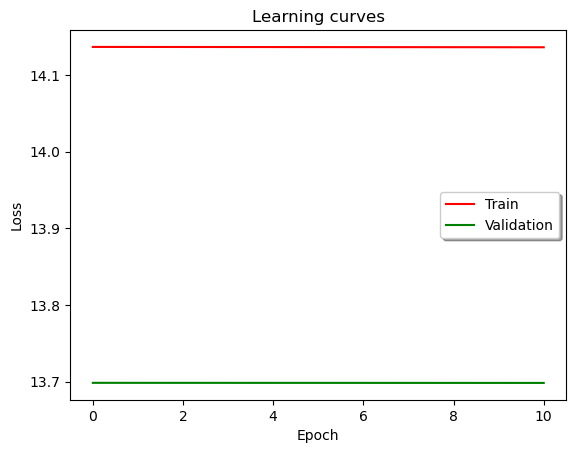

features: 3
learning rate: 1e-05
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.243248148710004
RMSE
3.7740228071263697


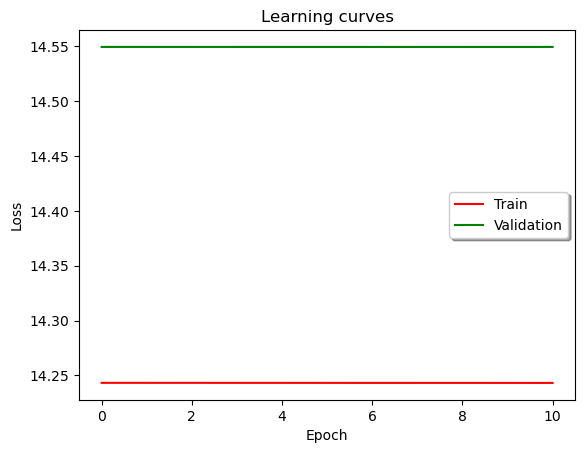

features: 3
learning rate: 1e-05
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.263671290079731
RMSE
3.7767275901340476


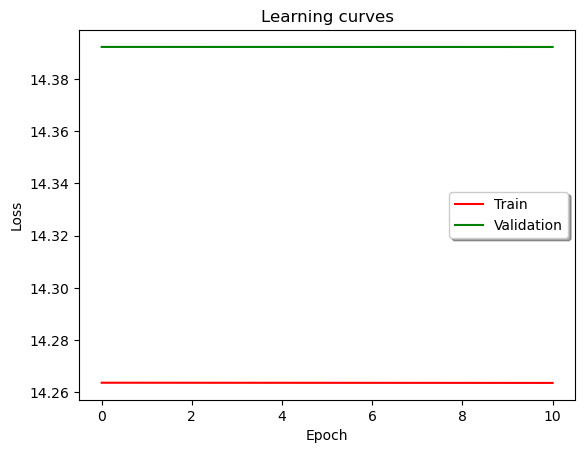

features: 3
learning rate: 1e-05
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.10169604653484
RMSE
3.755222502933061


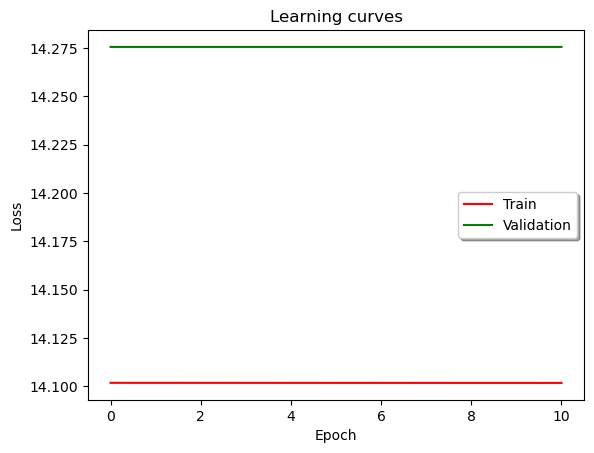

features: 5
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.090632178687256
RMSE
3.7537490830751135


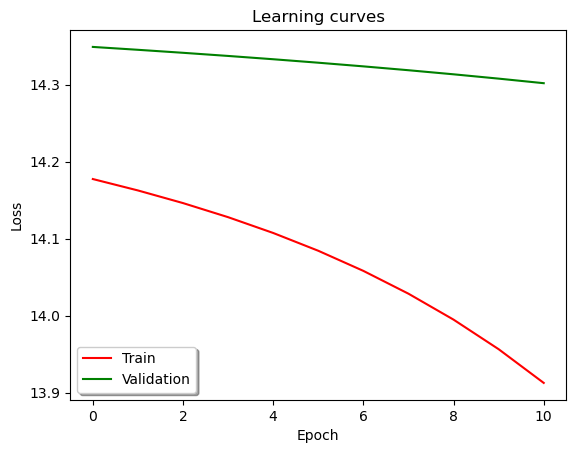

features: 5
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.26875827691885
RMSE
3.777400994985686


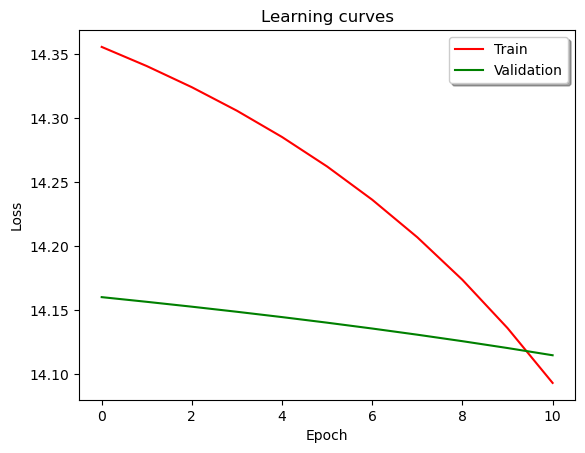

features: 5
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.23719442422268
RMSE
3.773220696463789


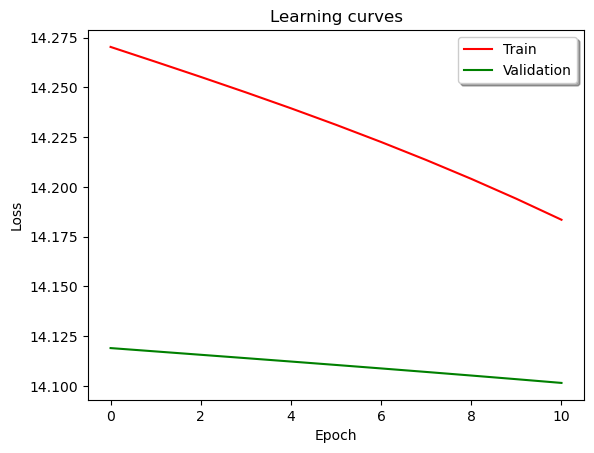

features: 5
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
13.953621953916072
RMSE
3.735454718493596


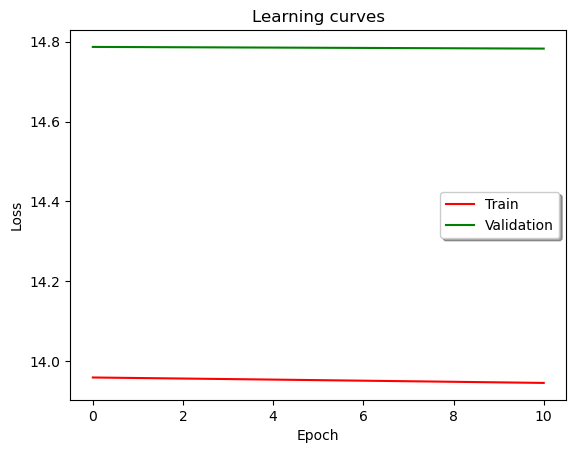

features: 5
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.262990995276187
RMSE
3.776637525005039


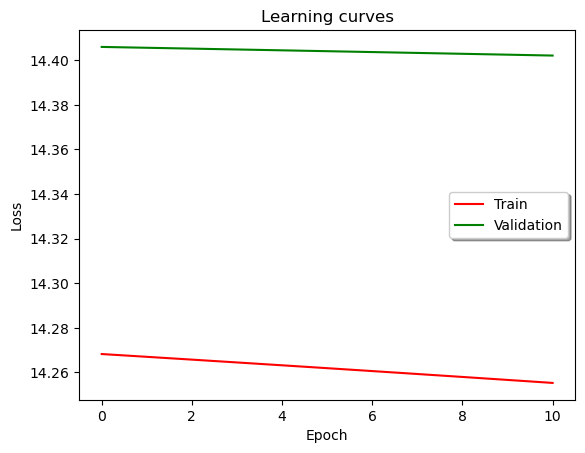

features: 5
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.077923933166067
RMSE
3.7520559608254866


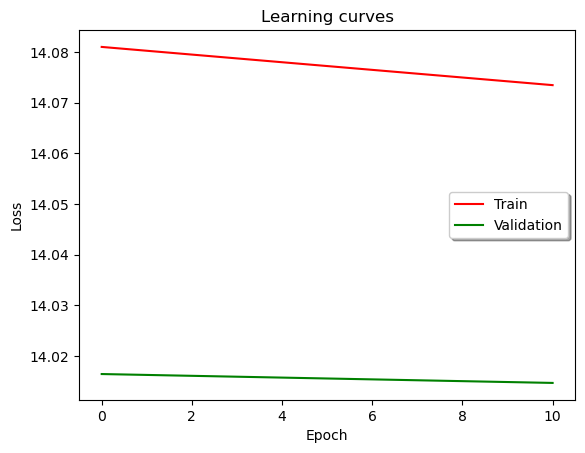

features: 5
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.289196572606972
RMSE
3.780105365278456


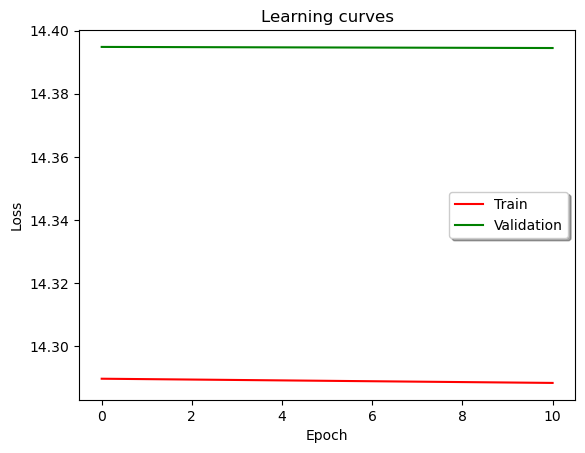

features: 5
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.27676543050242
RMSE
3.7784607223712703


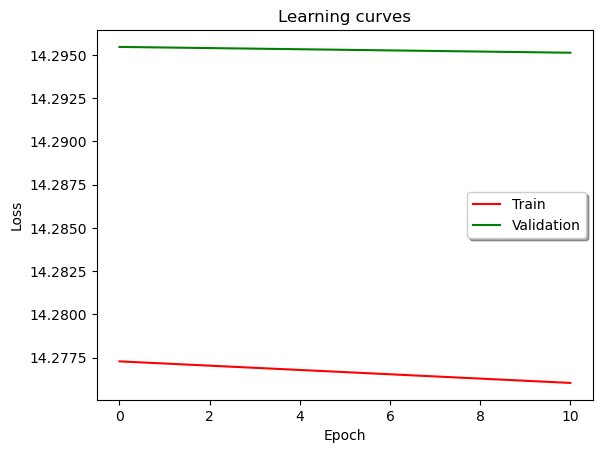

features: 5
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.171980058777137
RMSE
3.7645690402457936


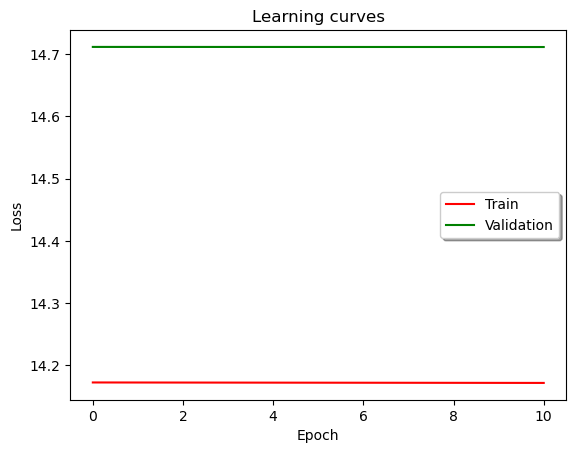

features: 5
learning rate: 1e-05
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.263696621412079
RMSE
3.776730943741171


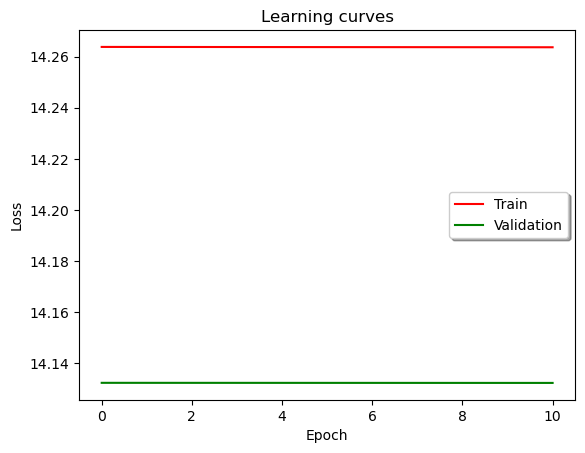

features: 5
learning rate: 1e-05
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.175993084875392
RMSE
3.7651020019217794


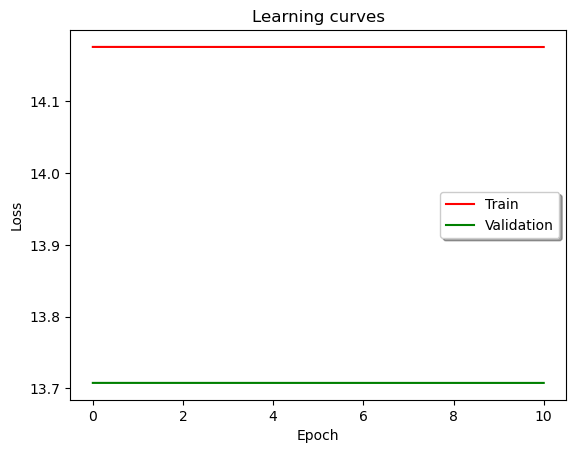

features: 5
learning rate: 1e-05
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.304535334990618
RMSE
3.7821337013636387


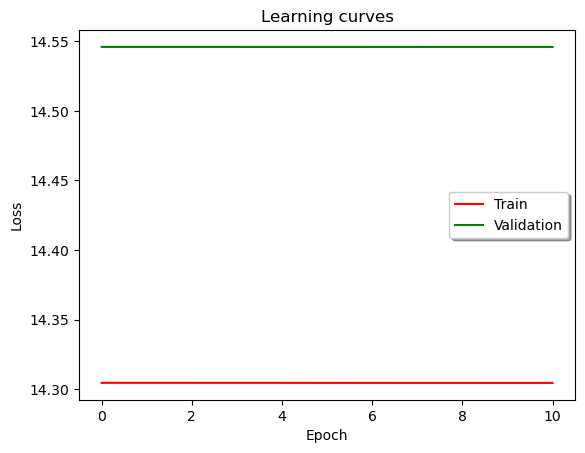

features: 10
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
13.7952278665584
RMSE
3.714192761093371


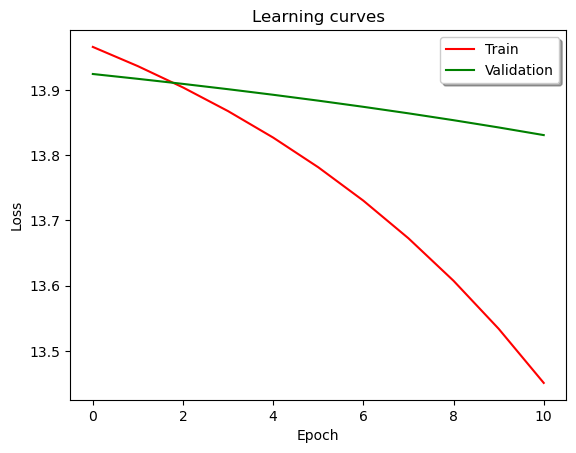

features: 10
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
13.916294061894234
RMSE
3.730454940338274


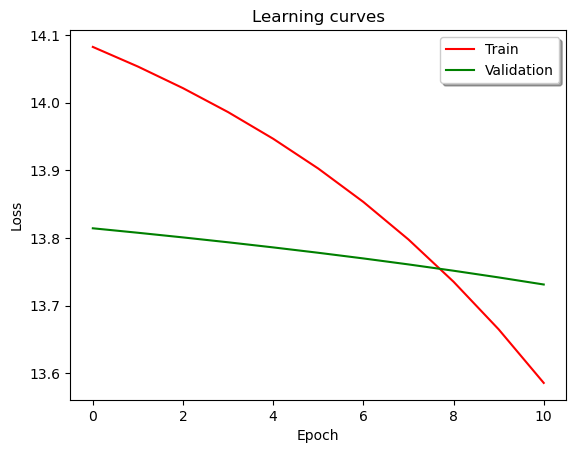

features: 10
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.051609904585101
RMSE
3.7485477060569874


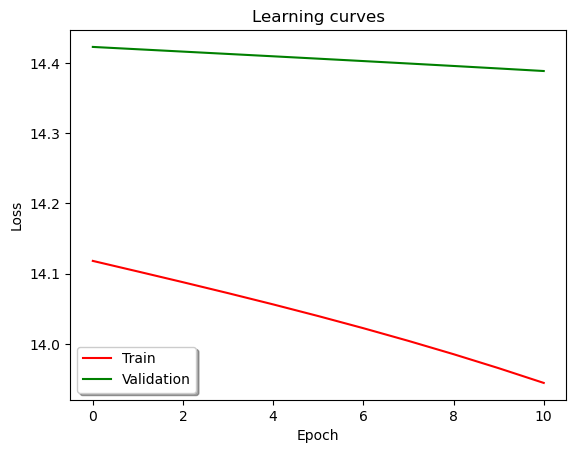

features: 10
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
13.836577200777638
RMSE
3.7197549920361204


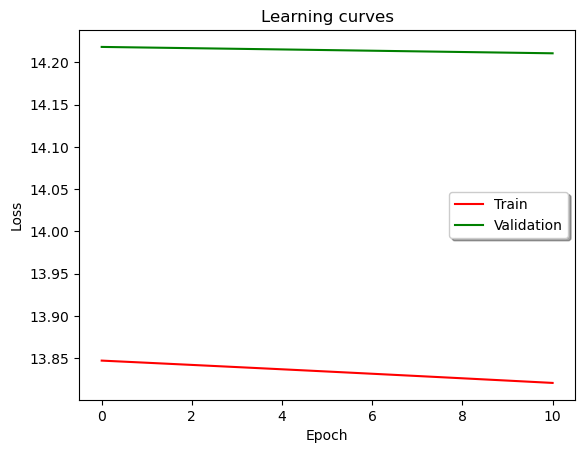

features: 10
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
14.069170835724828
RMSE
3.7508893393067235


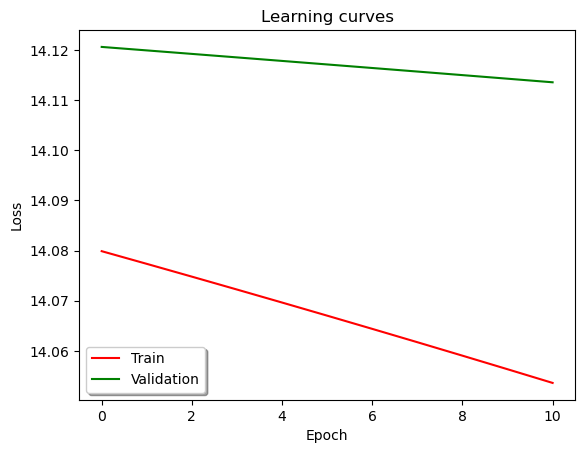

features: 10
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.050937520435578
RMSE
3.7484580190307026


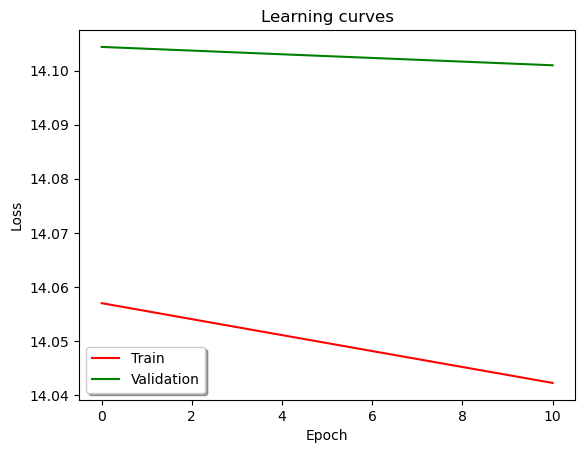

features: 10
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.096046597053283
RMSE
3.7544702152305436


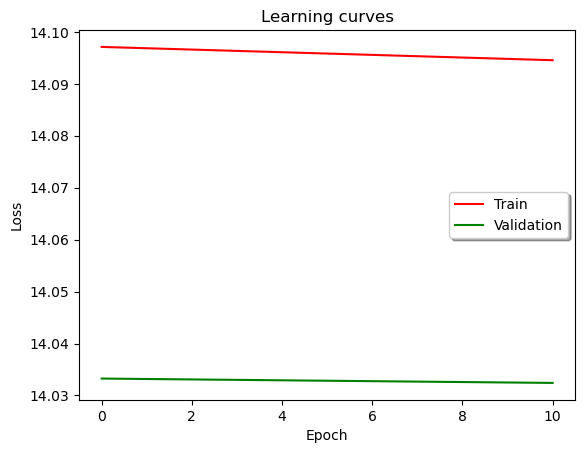

features: 10
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
13.944060018331276
RMSE
3.7341746100485547


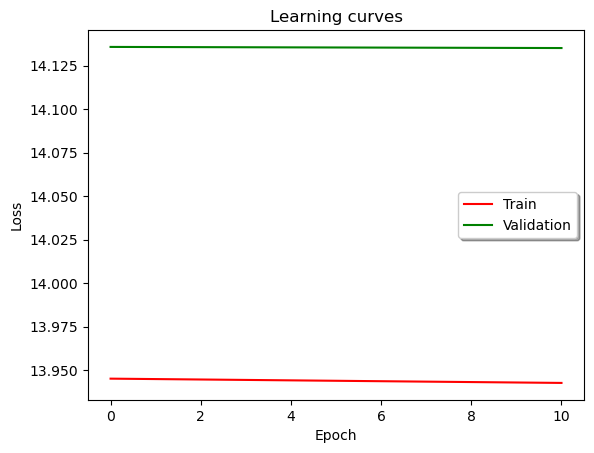

features: 10
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.063018950001975
RMSE
3.7500691926952463


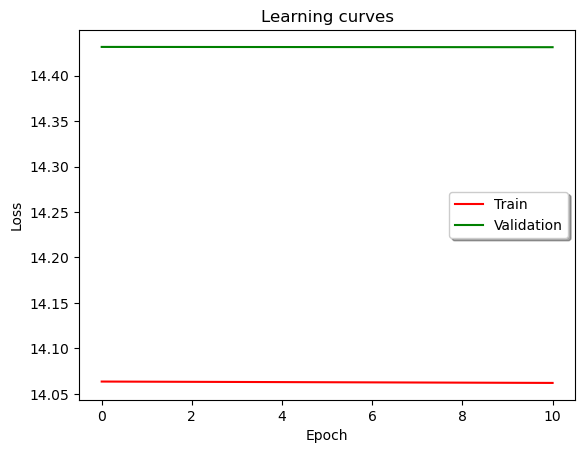

features: 10
learning rate: 1e-05
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
14.218564559925486
RMSE
3.770751193054971


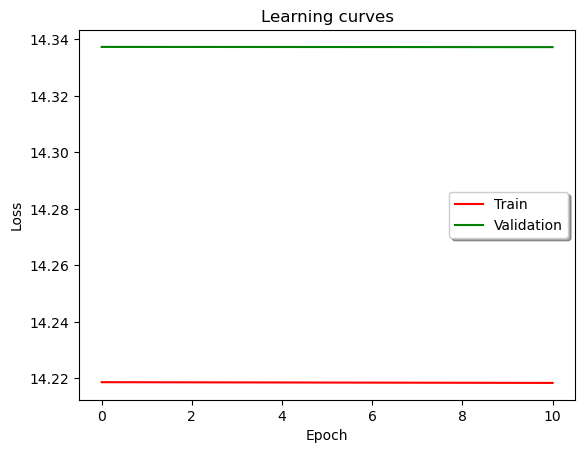

features: 10
learning rate: 1e-05
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
13.994696931509697
RMSE
3.740948667318184


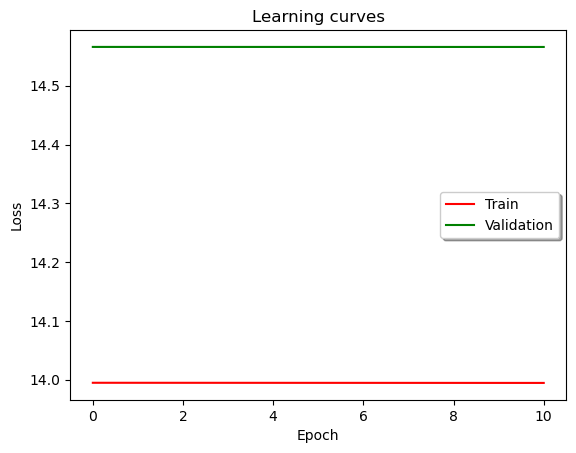

features: 10
learning rate: 1e-05
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
14.036707772546816
RMSE
3.7465594580290347


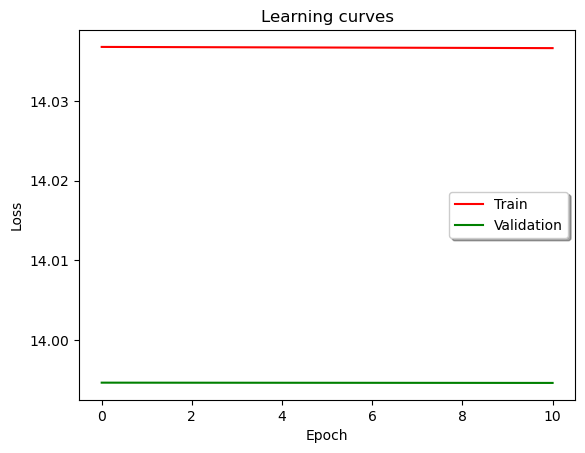

features: 100
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
10.807070165000546
RMSE
3.287410860388544


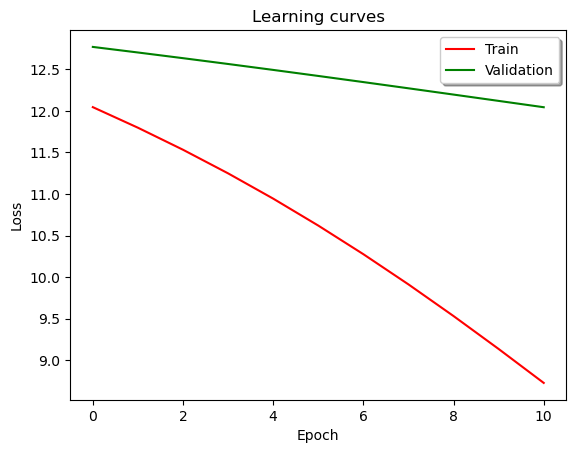

features: 100
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
11.060140811374277
RMSE
3.3256790000501066


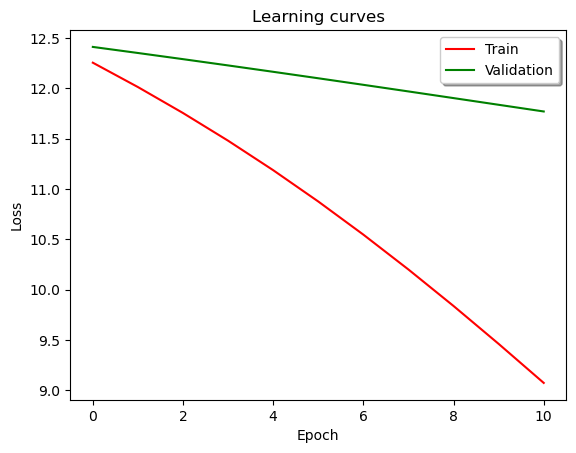

features: 100
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
11.93672073115685
RMSE
3.4549559666017235


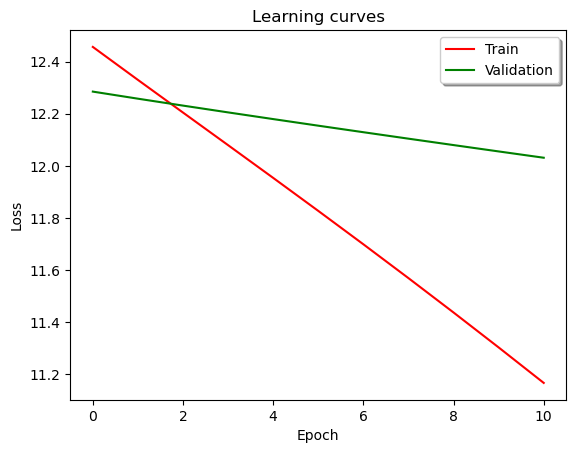

features: 100
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
12.55509398004758
RMSE
3.5433168049226955


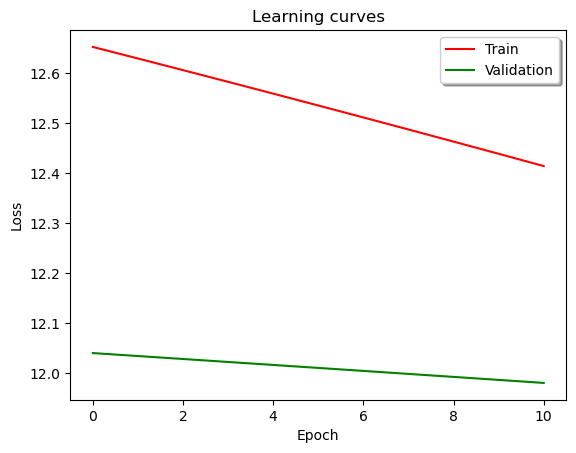

features: 100
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
12.403393757958513
RMSE
3.5218452206135513


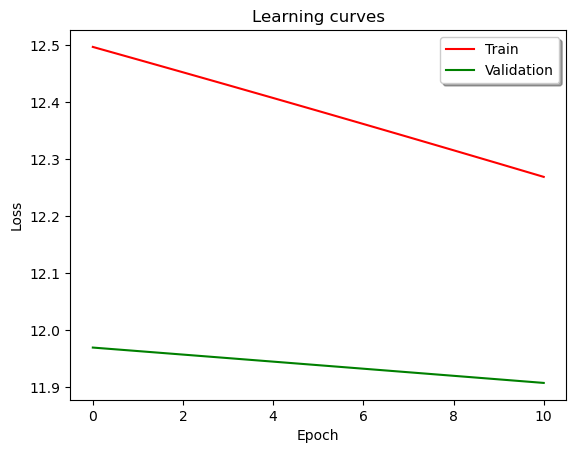

features: 100
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
12.585961777217
RMSE
3.5476699081533782


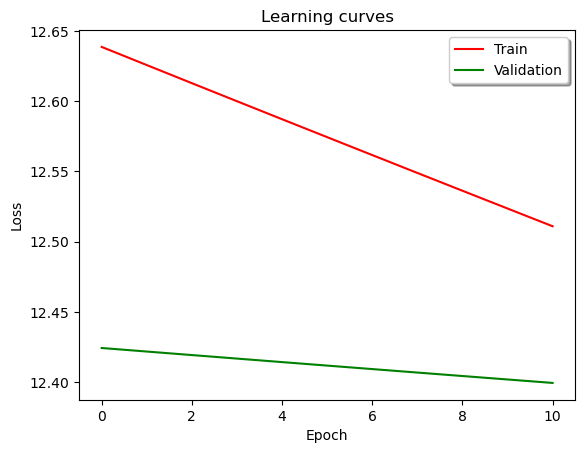

features: 100
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
12.613462847660069
RMSE
3.55154372740363


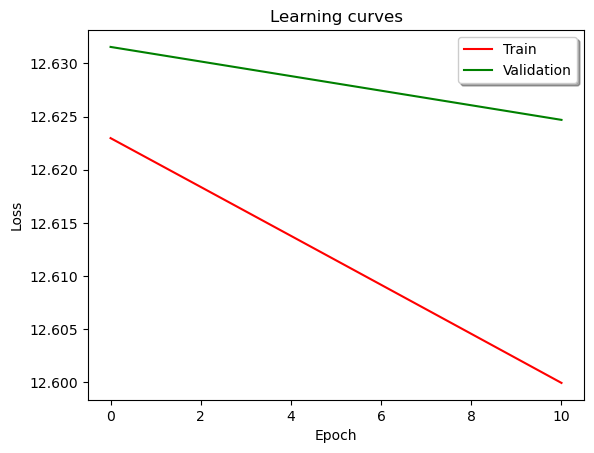

features: 100
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
12.6956160207475
RMSE
3.56309079602913


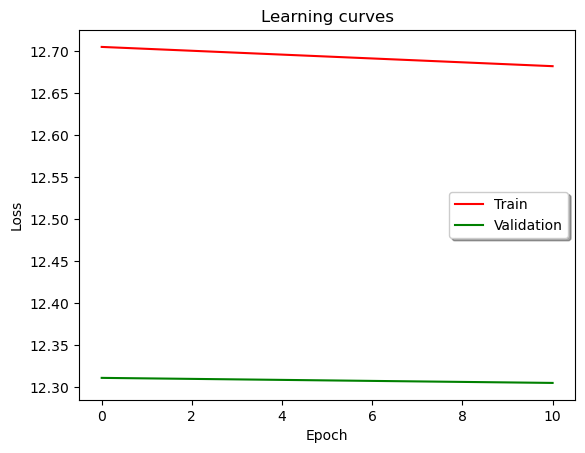

features: 100
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
12.702953973163734
RMSE
3.564120364572966


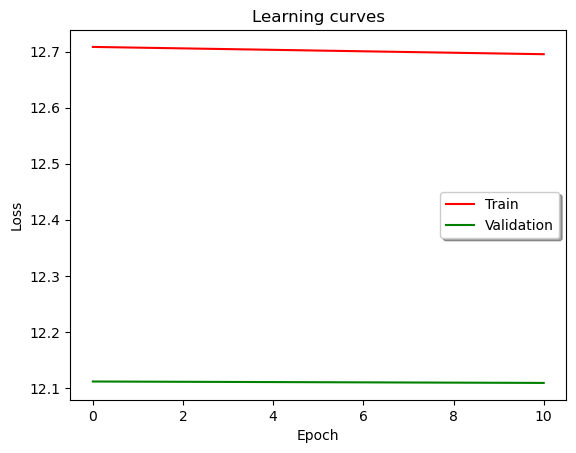

features: 100
learning rate: 1e-05
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
12.811043145644879
RMSE
3.57925175779029


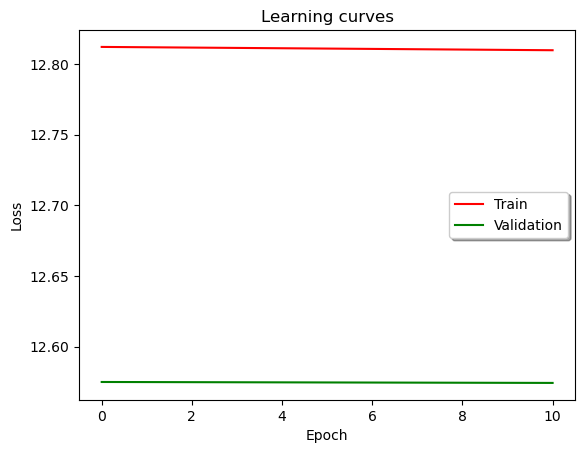

features: 100
learning rate: 1e-05
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
12.552373973370434
RMSE
3.5429329620203704


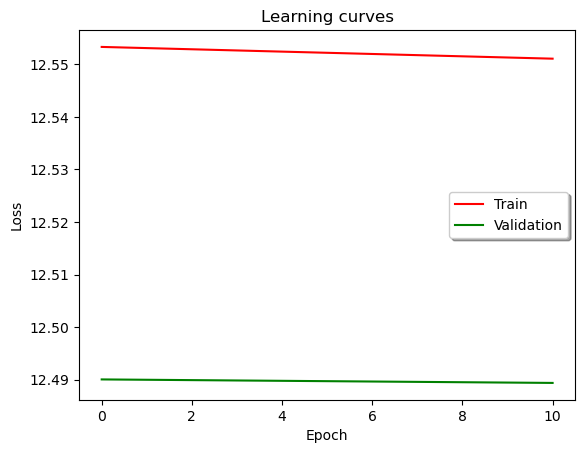

features: 100
learning rate: 1e-05
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
12.728959503724116
RMSE
3.5677667389732917


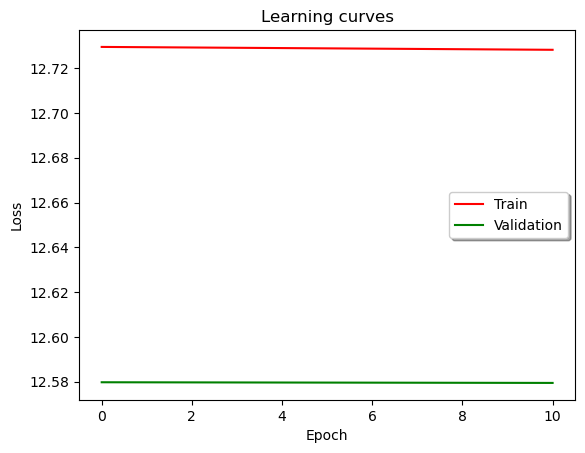

features: 200
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
8.495414928797224
RMSE
2.914689508128992


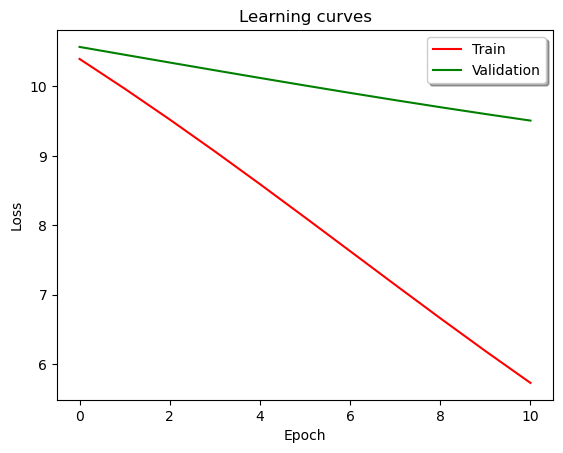

features: 200
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
8.663012682267487
RMSE
2.9432996249562304


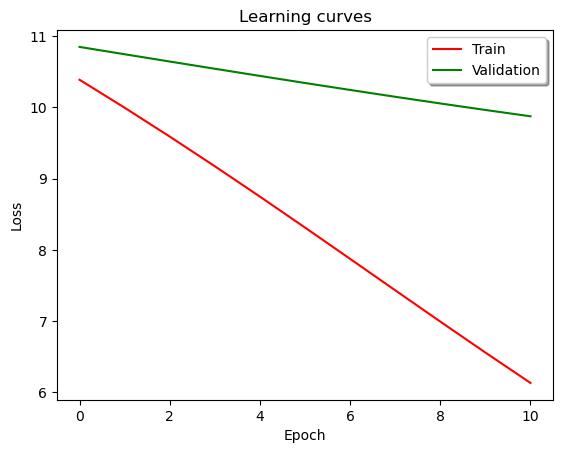

features: 200
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
9.966196351118501
RMSE
3.156928309467686


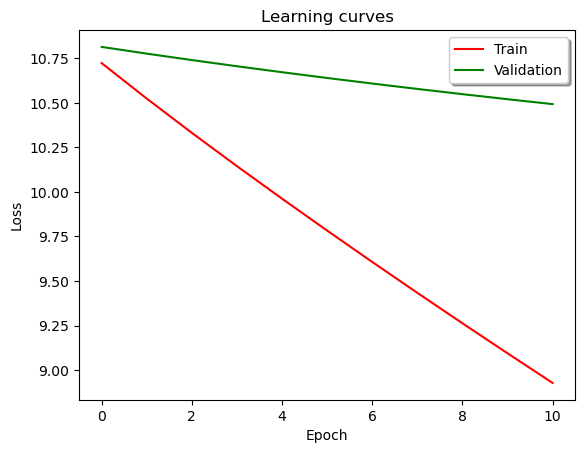

features: 200
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
10.626212322118622
RMSE
3.2597871590210645


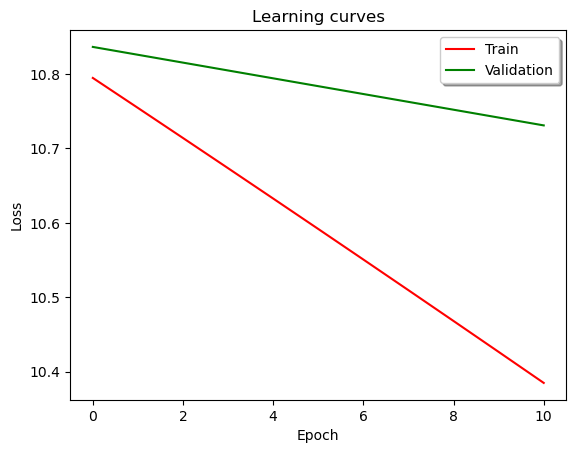

features: 200
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
10.790375291188115
RMSE
3.2848706658235596


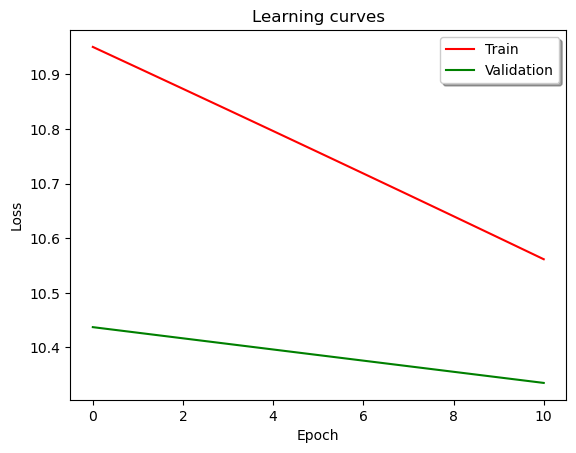

features: 200
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
10.830630269981945
RMSE
3.2909922926044577


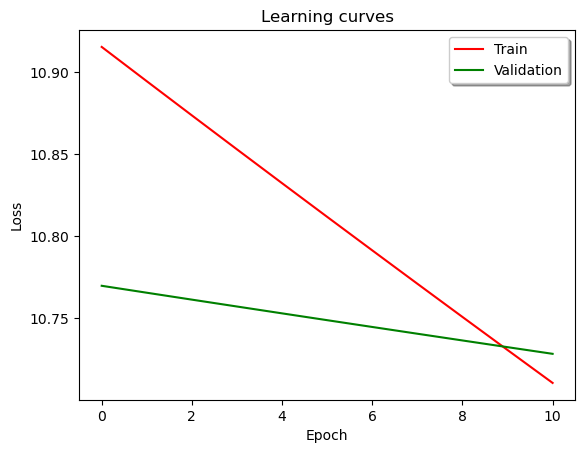

features: 200
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
10.781611741364294
RMSE
3.2835364687123993


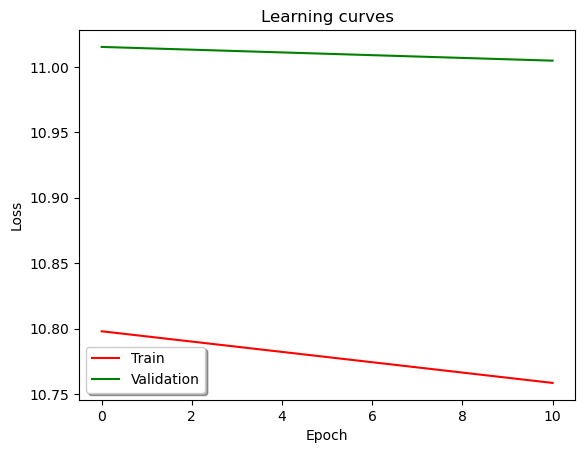

features: 200
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
10.98271243467112
RMSE
3.3140175670432286


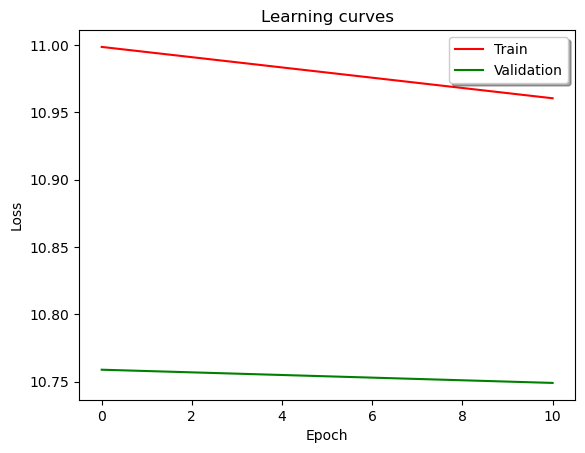

features: 200
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
11.071223324718474
RMSE
3.3273447859695087


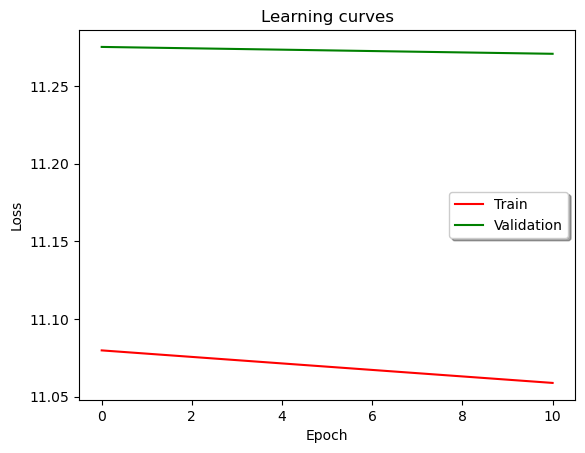

features: 200
learning rate: 1e-05
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
10.938724148390268
RMSE
3.307374207493048


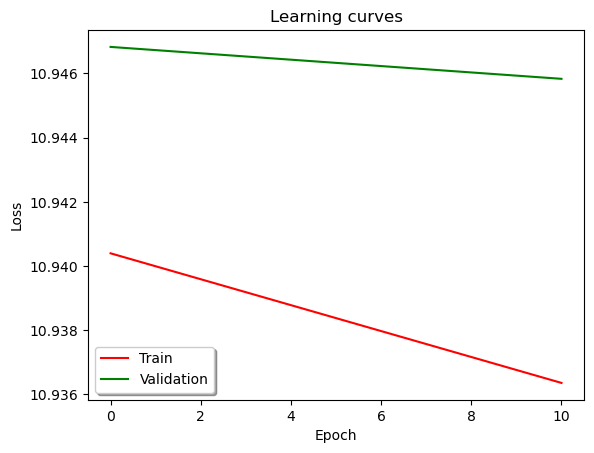

features: 200
learning rate: 1e-05
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
10.9726240107059
RMSE
3.3124951336878823


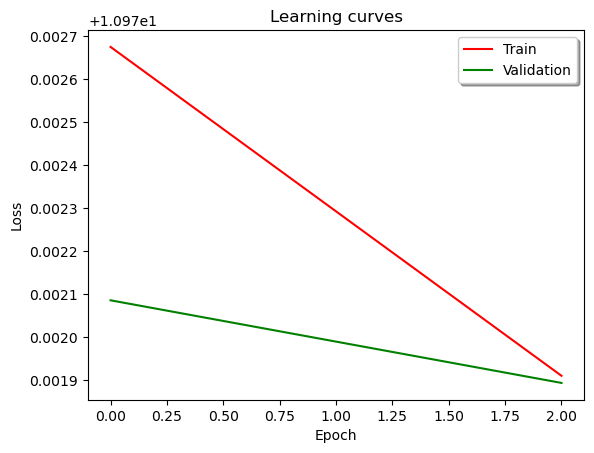

features: 200
learning rate: 1e-05
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
10.913996056678199
RMSE
3.303633765519144


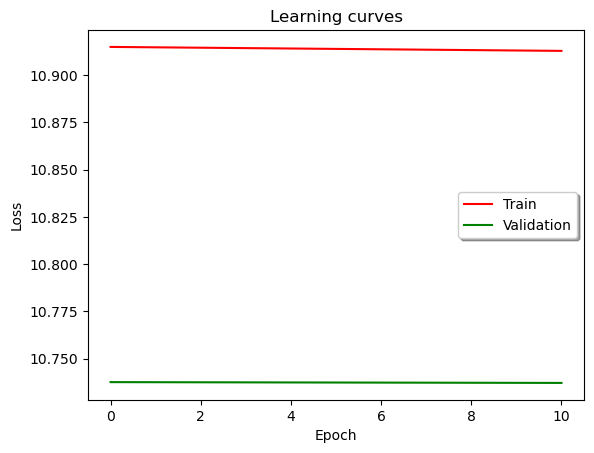

features: 300
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
6.820966708778012
RMSE
2.6116980508431697


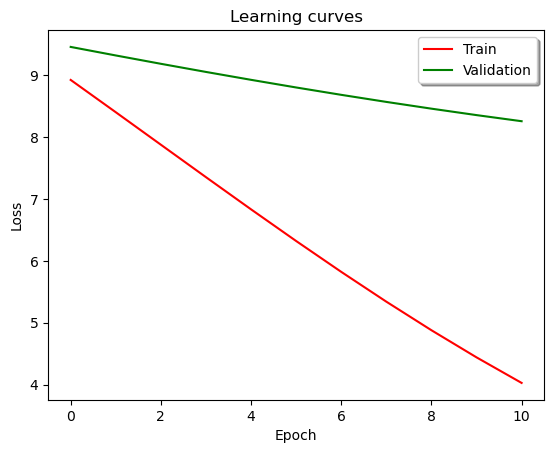

features: 300
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
6.846926357151359
RMSE
2.616663210493731


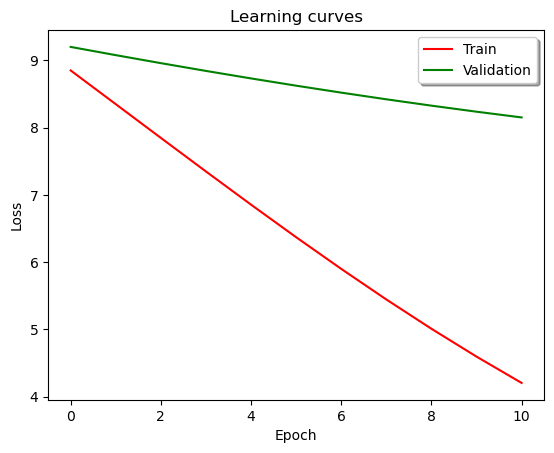

features: 300
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
8.346115515008558
RMSE
2.88896443643887


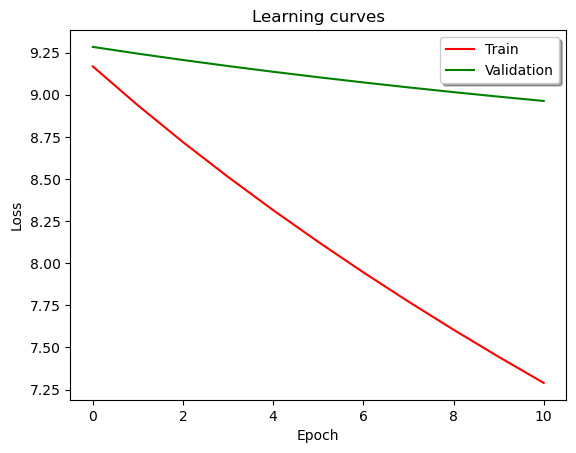

features: 300
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
9.282067097436157
RMSE
3.0466485024426686


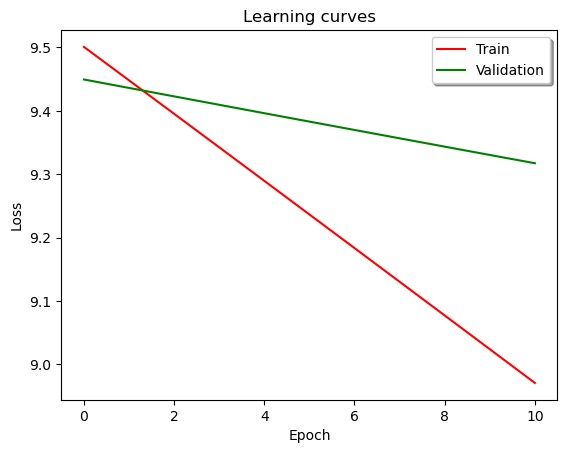

features: 300
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
9.161429107152983
RMSE
3.026785276023554


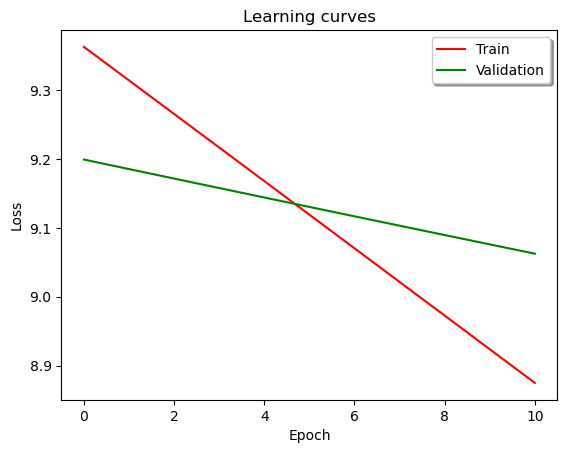

features: 300
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
9.331094803009936
RMSE
3.054684075810449


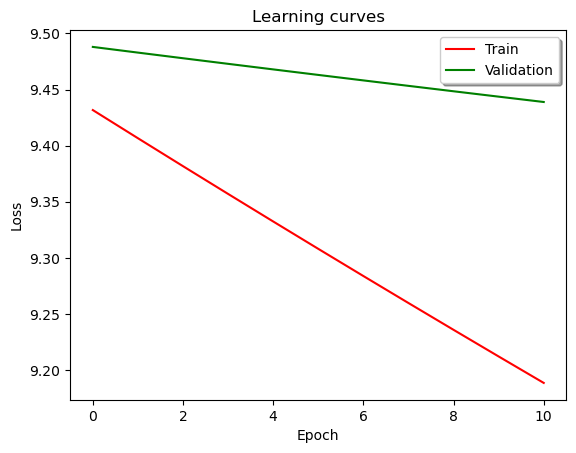

features: 300
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
9.25681994801088
RMSE
3.0425022511102404


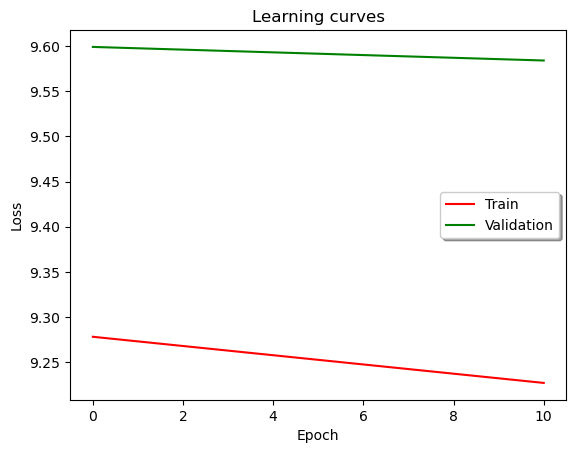

features: 300
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
9.464538330337628
RMSE
3.0764489806167155


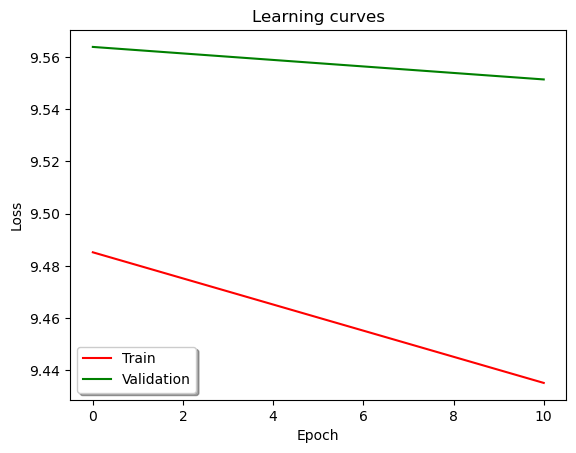

features: 300
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
9.656022961572035
RMSE
3.1074141921494847


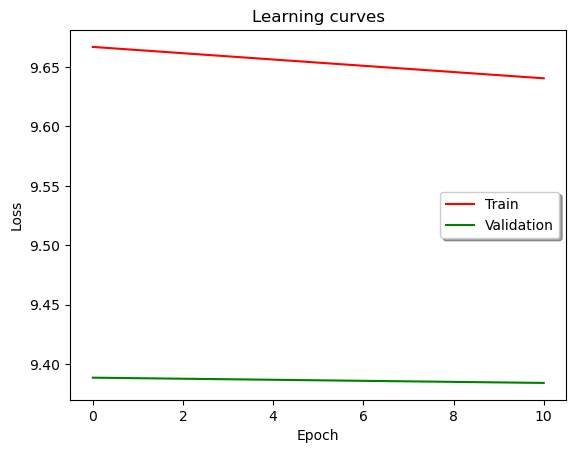

features: 300
learning rate: 1e-05
Epochs: 11
weight decay: 0.02
stopping: 0.001

MSE
9.49866916951746
RMSE
3.081991104710956


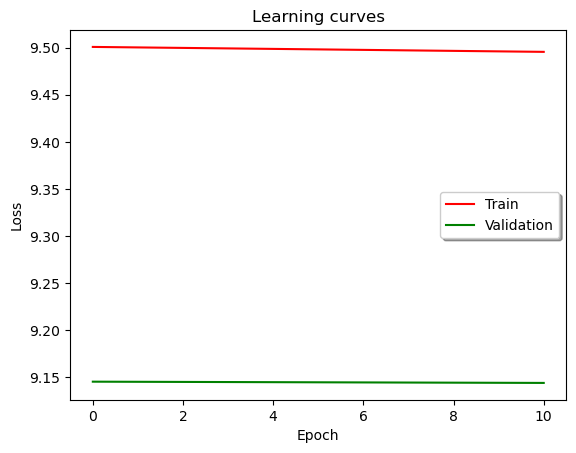

features: 300
learning rate: 1e-05
Epochs: 11
weight decay: 0.2
stopping: 0.001

MSE
9.457608264328915
RMSE
3.0753224650967765


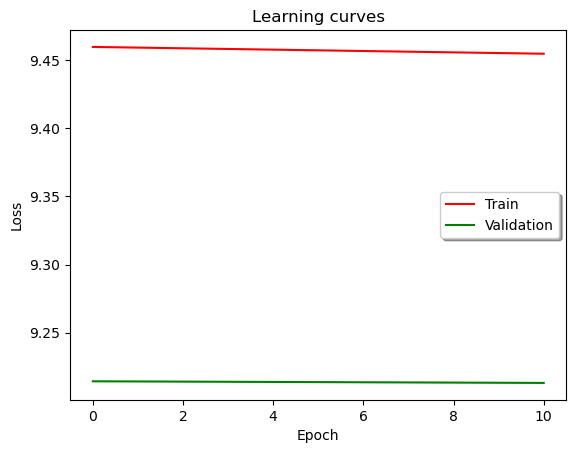

features: 300
learning rate: 1e-05
Epochs: 11
weight decay: 2
stopping: 0.001

MSE
9.40817030841282
RMSE
3.067274084331692


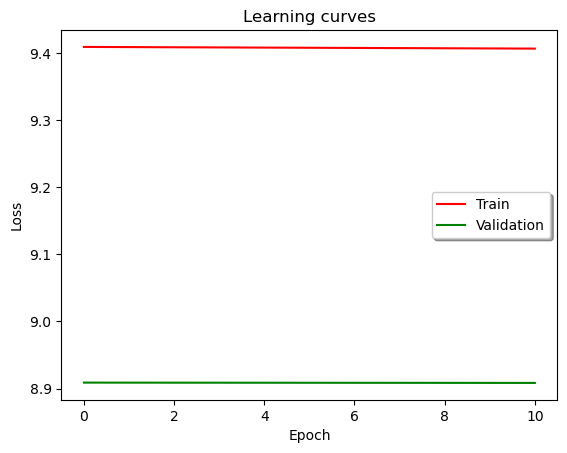

features: 3
learning rate: 0.01
Epochs: 101
weight decay: 0.02
stopping: 0.001

MSE
7.334612366047684
RMSE
2.7082489483147008


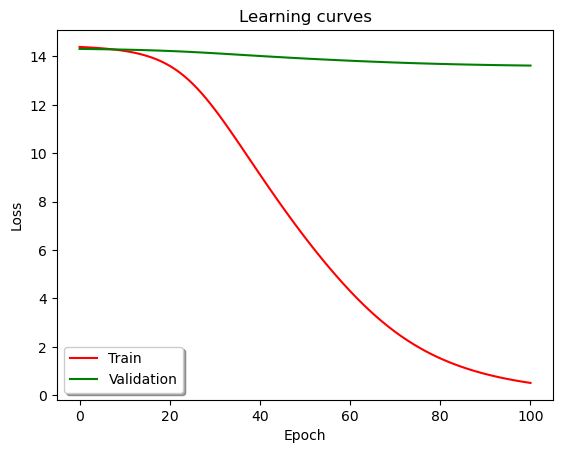

features: 3
learning rate: 0.01
Epochs: 101
weight decay: 0.2
stopping: 0.001

MSE
7.685523279883786
RMSE
2.7722776339832533


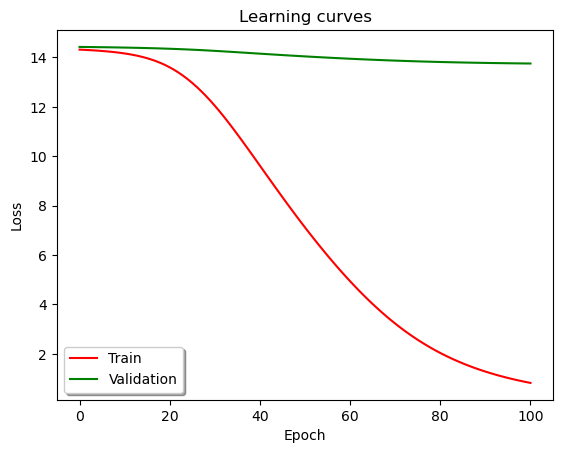

features: 3
learning rate: 0.01
Epochs: 101
weight decay: 2
stopping: 0.001

MSE
12.374711695829436
RMSE
3.51777084185844


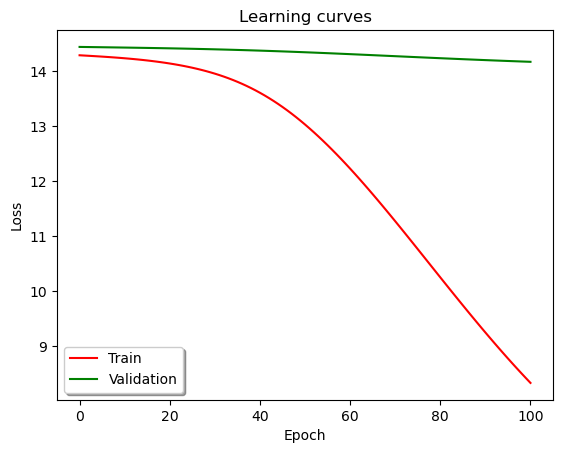

features: 3
learning rate: 0.001
Epochs: 101
weight decay: 0.02
stopping: 0.001

MSE
14.0960503633223
RMSE
3.7544707168018103


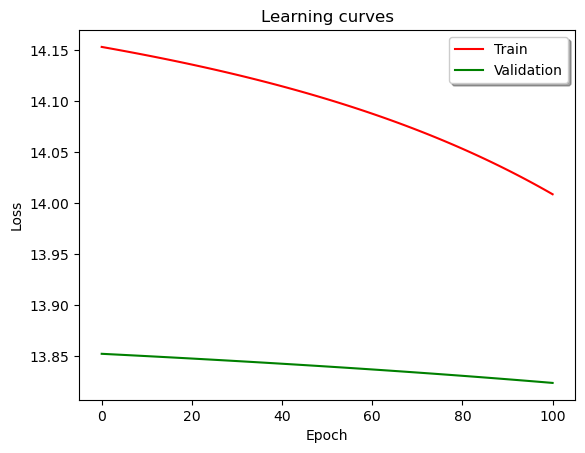

features: 3
learning rate: 0.001
Epochs: 101
weight decay: 0.2
stopping: 0.001

MSE
14.393041469472237
RMSE
3.7938162145091106


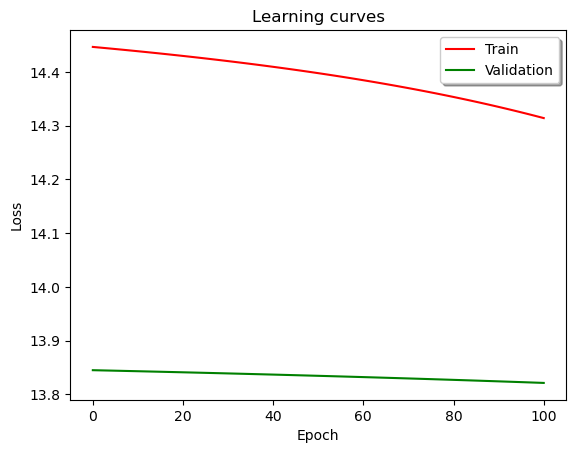

features: 3
learning rate: 0.001
Epochs: 101
weight decay: 2
stopping: 0.001

MSE
14.219127044061974
RMSE
3.7708257774739438


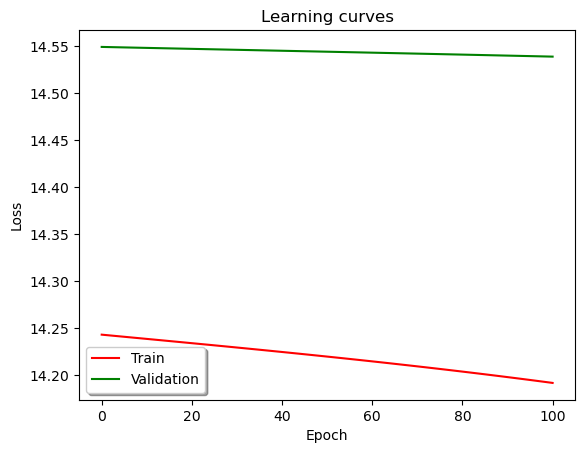

features: 3
learning rate: 0.0001
Epochs: 101
weight decay: 0.02
stopping: 0.001

MSE
14.166538999092904
RMSE
3.7638463038616368


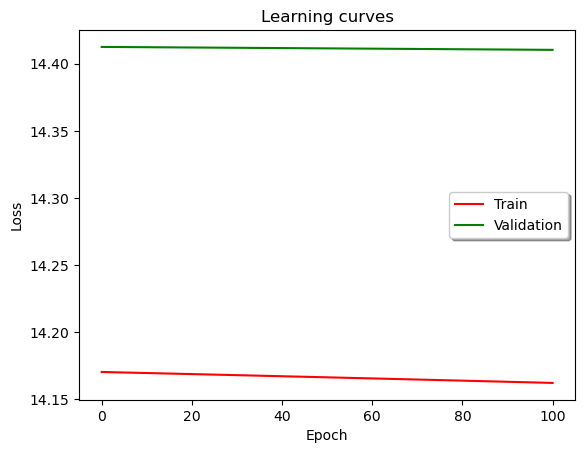

features: 3
learning rate: 0.0001
Epochs: 101
weight decay: 0.2
stopping: 0.001

MSE
14.221438136210026
RMSE
3.7711322087948633


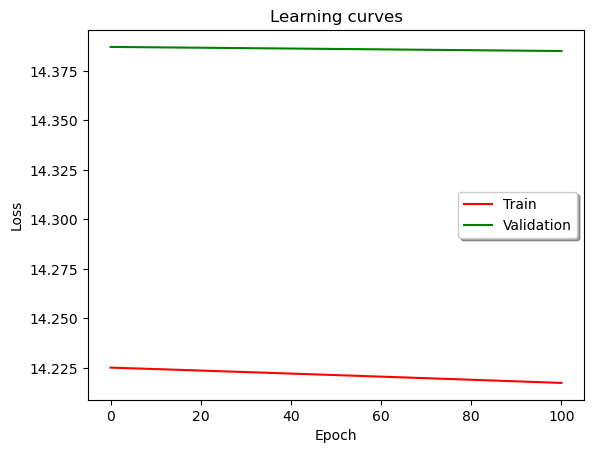

features: 3
learning rate: 0.0001
Epochs: 101
weight decay: 2
stopping: 0.001

MSE
14.176381437182396
RMSE
3.7651535741829174


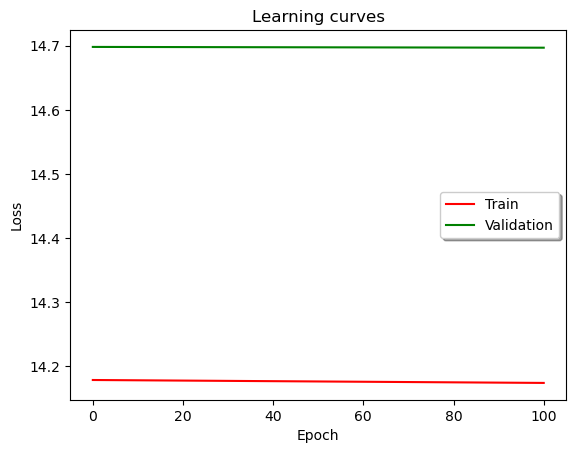

features: 3
learning rate: 1e-05
Epochs: 101
weight decay: 0.02
stopping: 0.001

MSE
14.290389257300669
RMSE
3.7802631201148778


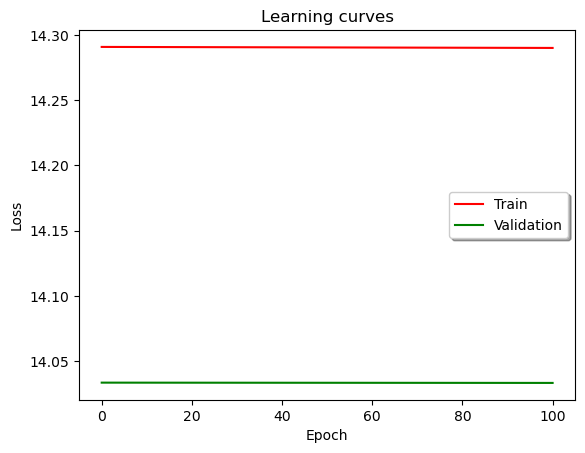

features: 3
learning rate: 1e-05
Epochs: 101
weight decay: 0.2
stopping: 0.001

MSE
14.068793445572995
RMSE
3.750839032213059


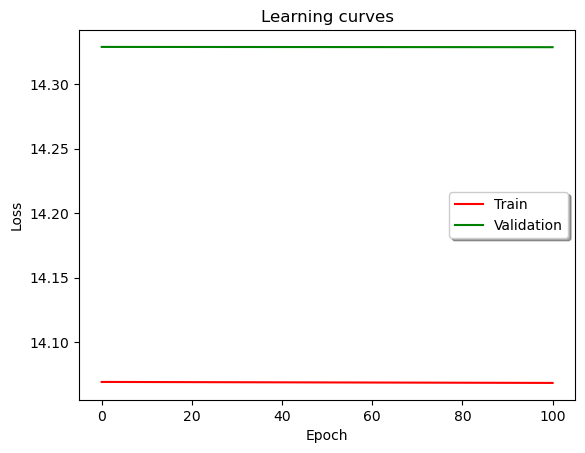

features: 5
learning rate: 0.01
Epochs: 101
weight decay: 0.02
stopping: 0.001

MSE
6.465962285168778
RMSE
2.542825649777974


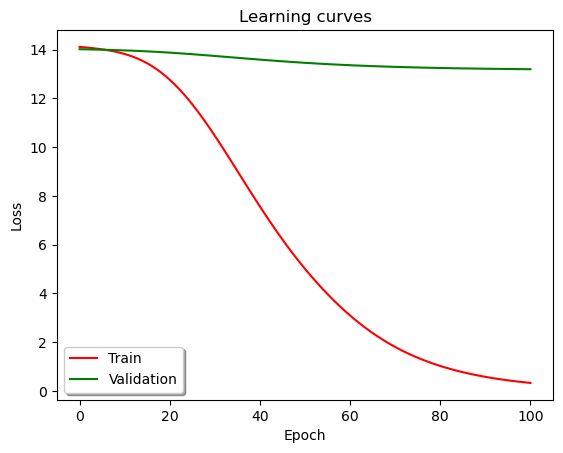

In [9]:
for epochs in PARAM['epochs']:
    for features in PARAM['features']:
        for lr in PARAM['lr']:
            for weight_decay in PARAM['weight_decay']:
                if os.path.isfile(f'./model_netflix/funk/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
#                     with open(f'./model_netflix/funk/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'rb') as inp:
#                         svd = pickle.load(inp)
#                         print(f'\nfeatures: {svd.features}\nlearning rate: {svd.lr}\nEpochs: {svd.epochs}\nweight decay: {svd.weight_decay}\nstopping: 0.001\n')
#                         inp.close()
                    with open(f'./model_netflix/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'rb') as inp:
                        print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n')
                        k=0
                        result = pickle.load(inp)
                        print('MSE')
                        print(sum(np.array(result[2])**2/len(result[2])))
                        print('RMSE')
                        print(np.sqrt(sum(np.array(result[2])**2/len(result[2]))))
                        plt.plot(list(range(len(result[0])))[-k:], result[0][-k:], 'r', label="Train")
                        plt.plot(list(range(len(result[1])))[-k:], result[1][-k:], 'g', label="Validation")
                        plt.title('Learning curves')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        leg = plt.legend(loc='best', shadow=True, fancybox=True)
                        plt.show()
                        inp.close()